<a href="https://colab.research.google.com/github/auroramugnai/ArXivClassification/blob/main/ArXivClassification/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the github repository and move to the inner directory.

In [1]:
!git clone https://github.com/auroramugnai/ArXivClassification.git
%cd ArXivClassification/ArXivClassification

Cloning into 'ArXivClassification'...
remote: Enumerating objects: 1754, done.
remote: Counting objects: 100% (396/396), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 1754 (delta 306), reused 271 (delta 230), pack-reused 1358
Receiving objects: 100% (1754/1754), 26.22 MiB | 15.92 MiB/s, done.
Resolving deltas: 100% (921/921), done.
/content/ArXivClassification/ArXivClassification


# 1) Build the dataset

In [2]:
import json
import os
import random
import zipfile

import dask.bag as db
import matplotlib.pyplot as plt
import pandas as pd

from utils import text_cleaner

In [3]:
SEED = 42 # fix random seed for reproducibility
random.seed(SEED)

## 1.1 Download the dataset
The following line of code comes from clicking on "Copy API command" in https://www.kaggle.com/datasets/Cornell-University/arxiv.

In [4]:
!kaggle datasets download -d Cornell-University/arxiv

Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv
License(s): CC0-1.0
100% 1.28G/1.28G [00:15<00:00, 62.8MB/s]
100% 1.28G/1.28G [00:16<00:00, 85.7MB/s]


Unzip the downloaded file.

In [5]:
with zipfile.ZipFile('./arxiv.zip', 'r') as zip_ref:
    zip_ref.extractall()

The unzipping creates an "arxiv-metadata-oai-snapshot.json". We now create a dask bag out of it.

In [6]:
path = "./arxiv-metadata-oai-snapshot.json"
arxiv_data = db.read_text(path).map(json.loads)
arxiv_data.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

## 1.2 Get rid of some unnecessary information

In [7]:
# Get the latest version of the articles.
get_latest_version = lambda x: x['versions'][-1]['created']

# Only keep articles published after 2022.
is_after_2022 = lambda x: int(get_latest_version(x).split(' ')[3]) > 2022

# Only keep articles that have at most 3 categories.
has_categs = lambda x: len(x['categories'].split(' ')) in {1}

# Only keep some information.
cut_info = lambda x: {'id': x['id'],
                      'title': x['title'],
                      'category':x['categories'].split(' '),
                      'abstract':x['abstract'],}

arxiv_data_filtered = (arxiv_data.filter(is_after_2022).filter(has_categs).map(cut_info).compute())
# arxiv_data_filtered = (arxiv_data.filter(is_after_2022).map(cut_info).compute())

# Create a pandas dataframe and save it to csv.
df = pd.DataFrame(arxiv_data_filtered)
# df.to_csv("./arxiv_data_filtered.csv", index=False)
df.head()

,id,title,category,abstract
0,0706.0190,Quantum Properties and Gravitational Field of ...,[physics.gen-ph],We find that a field with oscillations of ma...
1,0707.0434,Another generalization of Mason's ABC-theorem,[math.NT],We show a generalization of Mason's ABC-theo...
2,0707.3421,The nature of electromagnetic energy,[physics.gen-ph],The nature of electromagnetic energy for gen...
3,0707.4544,Orbital period derivative of a binary system u...,[physics.gen-ph],It is proposed that the equations of motion ...
4,0708.2658,"On positive opetopes, positive opetopic cardin...",[math.GT],We introduce the notion of a positive opetop...


## 1.3 Get a fixed number of articles
To speed up computation and avoid a session crash.

In [8]:
num_data = 20000 # number of articles that we want to keep
print(f"The dataset contains {len(df)} articles.")

# Sample the dataset only if its length exceeds num_data.
if(len(df) > num_data):
    n_sample = num_data
    df = df.sample(n=n_sample, axis=0, random_state=SEED)

print(f"The dataset contains {len(df)} articles.")

The dataset contains 150290 articles.
The dataset contains 20000 articles.


# 2) Text processing

In [9]:
!pip install -U spacy -q
!python -m spacy download en_core_web_md -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 13.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [10]:
import en_core_web_md
import spacy
from tqdm import tqdm

In [11]:
# Remove stop words, punctuation, special characters, numbers.
nlp = spacy.load("en_core_web_md")
tqdm.pandas() # to display progress bar

# First on abstracts.
clean_abs = lambda x: text_cleaner(text=x["abstract"], nlp=nlp)
df["clean_abstract"] = df.progress_apply(clean_abs, axis=1)

# Then on titles.
clean_tit = lambda x: text_cleaner(text=x["title"], nlp=nlp)
df["clean_title"] = df.progress_apply(clean_tit, axis=1)

df.tail()

100%|██████████| 20000/20000 [03:25<00:00, 97.40it/s] 


,id,title,category,abstract,clean_abstract,clean_title
142124,2404.03534,Some remarks on the Gram-Schmidt walk algorith...,[math.PR],In this paper we improve the best known cons...,paper improve know constant discrepancy formul...,remark gram schmidt walk algorithm consequence...
52531,2305.05365,Generalized binomial edge ideals of bipartite ...,[math.AC],Connected bipartite graphs whose binomial ed...,connect bipartite graph binomial edge ideal co...,generalize binomial edge ideal bipartite graph
98082,2310.19873,Asteroseismic g-mode period spacings in strong...,[astro-ph.SR],Strong magnetic fields are expected to signi...,strong magnetic field expect significantly mod...,asteroseismic g mode period spacing strongly m...
114452,2312.17020,Expansion of the Universe,[astro-ph.CO],I review the use of Type Ia supernovae (SNe ...,review use type ia supernovae sne ia discovery...,expansion universe
66409,2306.17522,Time Interfaces in Bianisotropic Media,[physics.optics],Wave phenomena in bianisotropic media have b...,wave phenomenon bianisotropic medium broadly s...,time interface bianisotropic medium


In [12]:
# Add a space to separate title and abstract.
df["clean_title"] = df["clean_title"].astype(str) + " "
df["text"] = df["clean_title"] + df["clean_abstract"]

# Save to csv.
# df.to_csv(f"./processed_dataframe.csv", index=False)
df.head()

,id,title,category,abstract,clean_abstract,clean_title,text
124893,2402.04824,Learning Communication Policies for Different ...,[cs.CL],Albrecht and Stone (2018) state that modelin...,albrecht stone state modeling change behavior ...,learn communication policies different followe...,learn communication policies different followe...
51014,2305.01959,Putting collective intelligence to the enforce...,[cs.CY],While underlying the many ways to build stro...,underlie way build strong cooperation setting ...,collective intelligence enforcement digital se...,collective intelligence enforcement digital se...
140897,2404.00882,Metric Learning to Accelerate Convergence of O...,[cs.LG],Recent work has shown a variety of ways in w...,recent work variety way machine learning use a...,metric learning accelerate convergence operato...,metric learning accelerate convergence operato...
145074,2404.09966,A fully Bayesian approach for the imputation a...,[stat.ME],Derived variables are variables that are con...,derive variable variable construct source vari...,fully bayesian approach imputation analysis de...,fully bayesian approach imputation analysis de...
123305,2402.00951,Comparing growth of titania and carbonaceous d...,[physics.plasm-ph],This study investigates the growth cycles of...,study investigate growth cycle titania carbona...,compare growth titania carbonaceous dusty nano...,compare growth titania carbonaceous dusty nano...


# 3) Vectorization

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
import operator

# Count the occurrencies of words in texts.
def count_word_occurrences(series):
    word_count = {}

    # Itera attraverso ciascun elemento della Series
    for text in series:
        words = text.split()  # split the texts in words
        for word in words:
            if word in word_count:
                word_count[word] += 1
            else:
                word_count[word] = 1

    return word_count

texts = df['text']

# Compute the words occurrencies in all the texts.
word_occurrences = count_word_occurrences(texts)

# Sort words by occurrence (from the most common to the least common)
sorted_words = sorted(word_occurrences.items(), key=operator.itemgetter(1),
                      reverse=True)

# Choose the number of most common words to include as max_features.
max_features = 10000

# Extract the first max_features most common words.
common_words = [word for word, count in sorted_words[:max_features]]

# # Convert the texts into a TF-IDF matrix.
tfidf_vectorizer = TfidfVectorizer(vocabulary=common_words)
X = tfidf_vectorizer.fit_transform(texts)
X.shape

(20000, 10000)

# 4) Dimensionality reduction with PCA

In [15]:
from sklearn.decomposition import PCA

In [16]:
# Reduce the dimensionality of the data to 3 for the 3D plot.
n_components = 3
pca = PCA(n_components=n_components, random_state=SEED)
X_reduced = pca.fit_transform(X.toarray())
X_reduced.shape

(20000, 3)

In [17]:
# Reduce the dimensionality of the data to 2 for the 2D plot.
pca2 = PCA(n_components=2, random_state=SEED)
X_reduced2 = pca2.fit_transform(X.toarray())
X_reduced2.shape

(20000, 2)

# 5) Find the number of clusters with K-Means

In [18]:
!pip install kneed -q

In [19]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from kneed import KneeLocator

<Figure size 640x480 with 0 Axes>

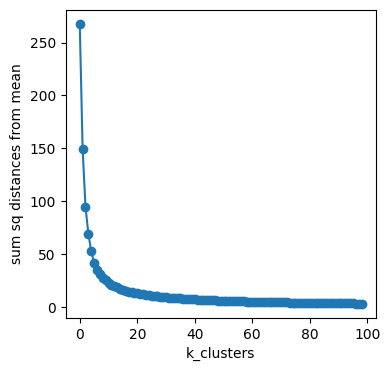

In [20]:
# Perform the cluster algorithm k_max times and calculate the ssd from mean.
cluster_errors = []

k_max = 100
for i in range(1, k_max):
    n_clusters = i
    pipe_pca_kmean = Pipeline([("cluster", KMeans(n_init='auto',
                                                  n_clusters=n_clusters,
                                                  random_state=SEED,
                                                  verbose=0)
                                )])

    pipe_pca_kmean.fit(X_reduced2)
    pipe_pca_kmean.predict(X_reduced2)
    cluster_errors.append(pipe_pca_kmean.named_steps["cluster"].inertia_)

# Plot the sum squared distances from mean.
plt.clf()
plt.figure(figsize=(4,4))
plt.plot(cluster_errors, "o-")
plt.xlabel("k_clusters")
plt.ylabel("sum sq distances from mean")
plt.show()

In [21]:
# Find the optimal value of k with KneeLocator.
kl = KneeLocator(range(1, k_max), cluster_errors, curve="convex",
                 direction="decreasing")

# 6) Predict the clusters on our dataset

In [22]:
k_optimal = kl.elbow

print('k_optimal = ', k_optimal)

k_optimal =  9


In [23]:
from sklearn.cluster import KMeans

In [24]:
# Predict the clusters.
kmeans = KMeans(n_clusters=k_optimal, init='k-means++', random_state=SEED, n_init='auto')
y_pred = kmeans.fit_predict(X_reduced)
y_pred2 = kmeans.fit_predict(X_reduced2)

## 6.1 Calculate clustering metrics

In [25]:
import matplotlib.cm as cm
import numpy as np
from sklearn.metrics import silhouette_score, silhouette_samples

The average silhouette score is: 0.3799781575004079


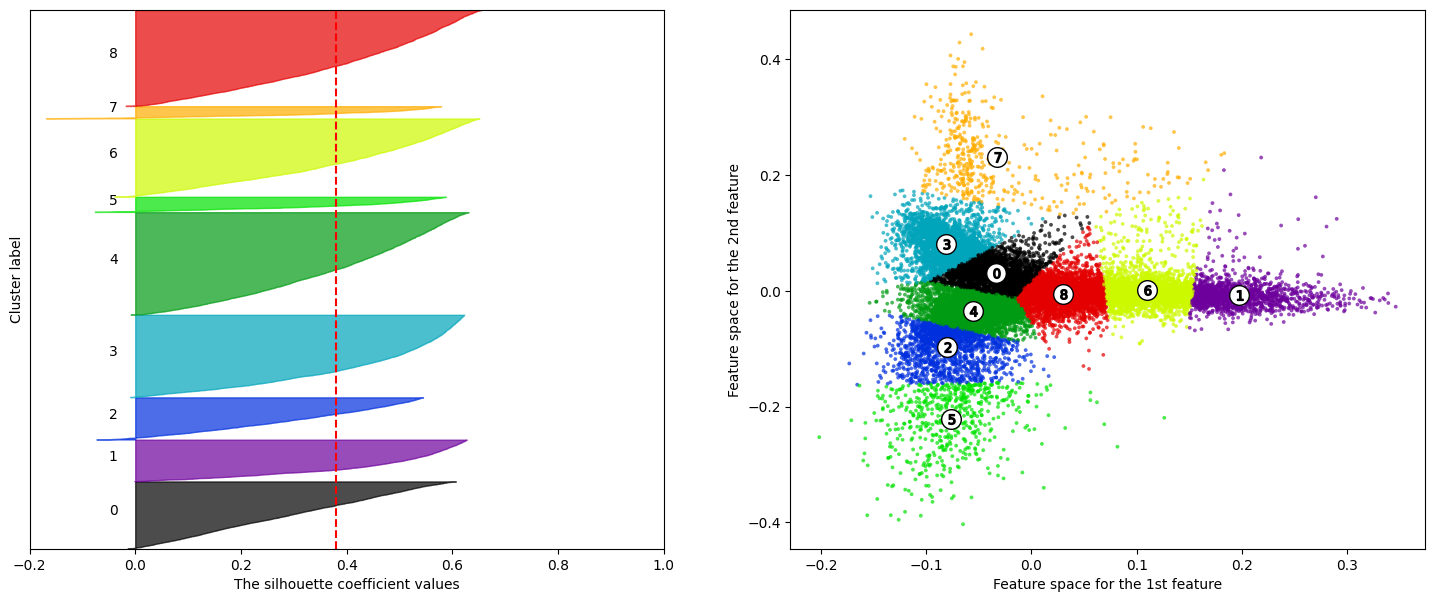

In [26]:
n_clusters = k_optimal

# Create a subplot with 1 row and 2 columns.
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The first subplot is the silhouette plot.
ax1.set_xlim([-0.2, 1])
ax1.set_ylim([0, len(X_reduced2) + (n_clusters + 1) * 10]) # insert blanck space between silhouette plots of individual clusters

# The silhouette_score gives the average value for all the samples.
silhouette_avg = silhouette_score(X_reduced2, y_pred2)
print("The average silhouette score is:", silhouette_avg)

# Compute the silhouette scores for each sample.
sample_silhouette_values = silhouette_samples(X_reduced2, y_pred2)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[y_pred2 == i]
    # Sort them.
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0,
                      ith_cluster_silhouette_values,
                      facecolor=color,
                      edgecolor=color,
                      alpha=0.7,
                      )

    # Label the silhouette plots with their cluster numbers at the middle.
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot.
    y_lower = y_upper + 10

ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values.
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed.
colors = cm.nipy_spectral(y_pred2.astype(float) / n_clusters)
ax2.scatter(X_reduced2[:, 0], X_reduced2[:, 1], marker=".", s=30, lw=0,
            alpha=0.7, c=colors, edgecolor="k"
            )

# Labeling the clusters.
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers.
ax2.scatter(centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="k",
            )

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

plt.show()

# 7) Plot the clusters with UMAP


In [27]:
!pip install umap-learn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 369.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.7 MB/s eta 0:00:00


In [28]:
import plotly.express as px
from umap import UMAP

In [29]:
# UMAP definition.
umap_embeddings = UMAP(min_dist=0.1, n_components=n_components)
X_umap = umap_embeddings.fit_transform(X_reduced)


# Plot.
x, y, z = list(zip(*X_umap))
fig = px.scatter_3d(df, x, y, z, color=y_pred.astype(str),
                    color_discrete_sequence=px.colors.qualitative.Dark24,
                    hover_data=['category', 'title'])
fig.update_traces(marker_size=3)
fig.show()

In [30]:
# Save interacting 3D plot as html.
fig.write_html('clustering_plot.html', auto_open=True)